field AcadosOcpDims.N has been migrated to AcadosOcpOptions.N_horizon. setting AcadosOcpOptions.N_horizon = N. For future comppatibility, please use AcadosOcpOptions.N_horizon directly.
 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.6.7 currently in use.
rm -f libacados_ocp_solver_simplependulum_ode_init.so
rm -f simplependulum_ode_init_constraints/simplependulum_ode_init_constr_h_fun_jac_uxt_zt.o simplependulum_ode_init_constraints/simplependulum_ode_init_constr_h_fun.o simplependulum_ode_init_constraints/simplependulum_ode_init_constr_h_e_fun_jac_uxt_zt.o simplependulum_ode_init_constraints/simplependulum_ode_init_constr_h_e_fun.o acados_solver_simplependulum_ode_init.o
cc -fPIC -std=c99   -O2 -I/home/amon/Repositories/l4acados/external/acados/include -I/home/amon/Repositories/l4acados/external/acados/include/acados -I/home/amon/Repositories/l4acados/external/acados/include/blasfeo/include -I/home/amon/Repositor

/tmp/ipykernel_109756/656743236.py:244: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(train_data_path)
/home/amon/.pyenv/versions/3.9.13/envs/l4acados

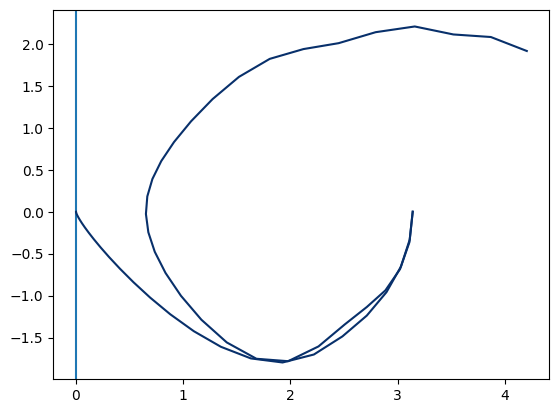

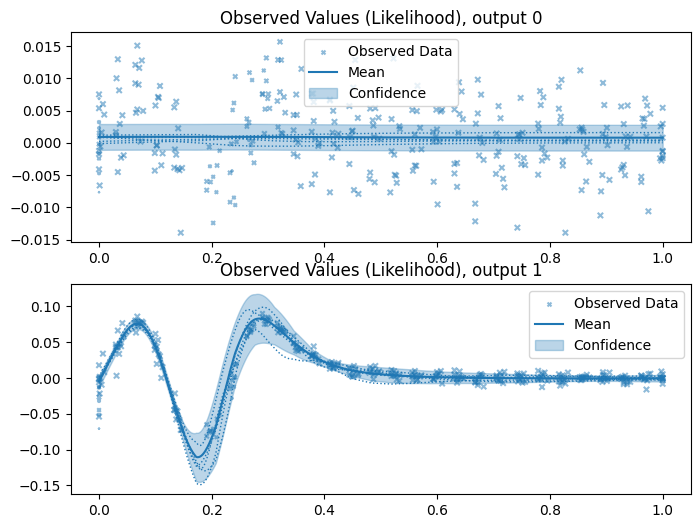

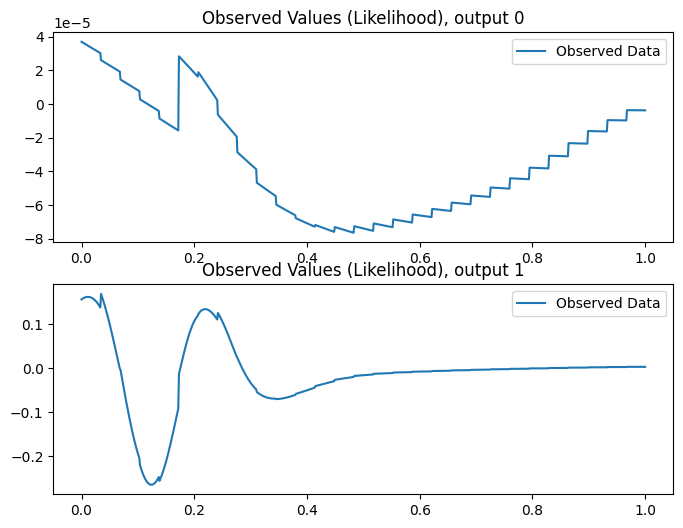

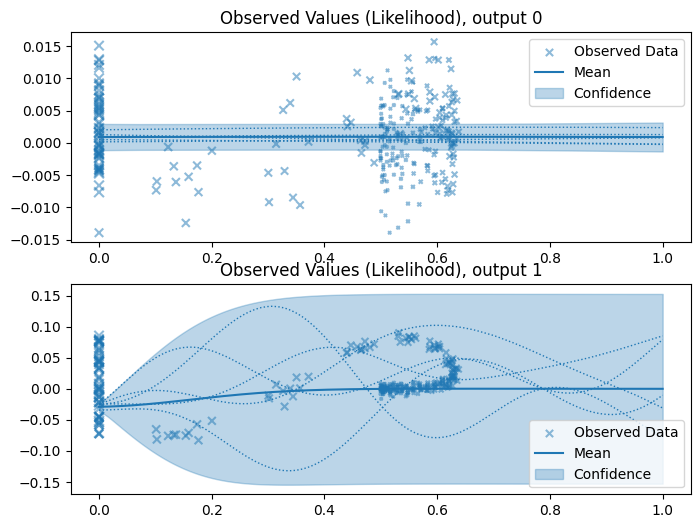

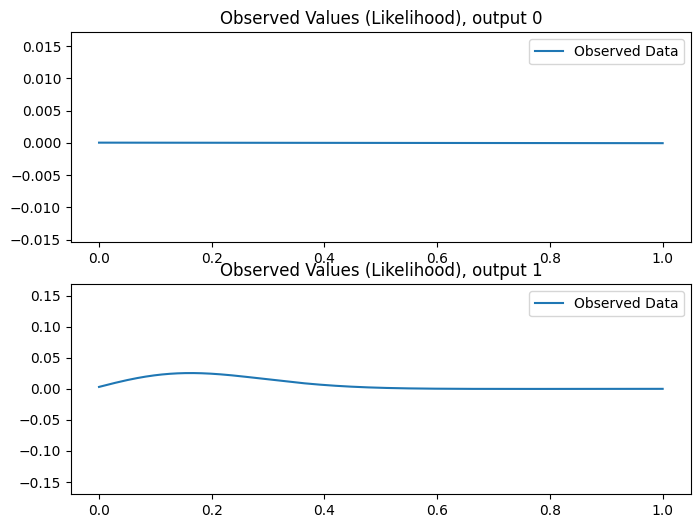

In [1]:
# + metadata={}
import sys, os

# + metadata={}
%load_ext autoreload
%autoreload 1
%aimport l4acados

# + metadata={}
import numpy as np
from scipy.stats import norm
import casadi as cas
from acados_template import (
    AcadosOcp,
    AcadosSim,
    AcadosSimSolver,
    AcadosOcpSolver,
    AcadosOcpOptions,
    ZoroDescription,
)
import matplotlib.pyplot as plt
import torch
import gpytorch
import copy

# zoRO imports
import l4acados
from l4acados.controllers import (
    ZeroOrderGPMPC,
)
from l4acados.controllers.zoro_acados_utils import setup_sim_from_ocp
from inverted_pendulum_model_acados import (
    export_simplependulum_ode_model,
    export_ocp_nominal,
)
from utils import *

# gpytorch_utils
from gp_hyperparam_training import (
    generate_train_inputs_acados,
    generate_train_outputs_at_inputs,
    train_gp_model,
)
from gp_utils import (
    gp_data_from_model_and_path,
    gp_derivative_data_from_model_and_path,
    plot_gp_data,
    generate_grid_points,
)
from l4acados.models.pytorch_models.gpytorch_models.gpytorch_gp import (
    BatchIndependentMultitaskGPModel,
)

# -


# ## Define model parameters
#
# We model the inverted pendulum
#
# $$
# \dot{x} = f(x,u) = \begin{bmatrix} \dot{\theta} \\ \ddot{\theta} \end{bmatrix} = \begin{bmatrix} \dot{\theta} \\ -\sin(\theta) + u \end{bmatrix},
# $$
#
# which is to be controlled from the hanging-down resting position, $(\theta_0, \dot{\theta}_0) = (\pi, 0)$, to the upright position $(\theta_r, \dot{\theta}_r) = (0,0)$, subject to the constraints that overshoot should be avoided, i.e.,
#
# $$
# \theta_{lb} \leq \theta \leq \theta_{ub}.
# $$
#
# The model setup and controller definition can be found in the functions `export_simplependulum_ode_model()`, `export_ocp_nominal()` in the `inverted_pendulum_model_acados.py` file.

# + metadata={}
# build C code again?
build_c_code = True

# + metadata={}
# discretization
N = 30
T = 5
dT = T / N

# constraints
x0 = np.array([np.pi, 0])
nx = 2
nu = 1


# + metadata={}
prob_x = 0.95
prob_tighten = norm.ppf(prob_x)

# noise
# uncertainty dynamics
sigma_theta = (0.0001 / 360.0) * 2 * np.pi
sigma_omega = (0.0001 / 360.0) * 2 * np.pi
w_theta = 0.005
w_omega = 0.005
Sigma_x0 = np.array([[sigma_theta**2, 0], [0, sigma_omega**2]])
Sigma_W = np.array([[w_theta**2, 0], [0, w_omega**2]])
# -

# ## Set up nominal solver

# + metadata={}
ocp_init = export_ocp_nominal(N, T, model_name="simplependulum_ode_init")
ocp_init.solver_options.nlp_solver_type = "SQP"

# + metadata={}
ocp_init.solver_options.Tsim

# + metadata={}
acados_ocp_init_solver = AcadosOcpSolver(
    ocp_init, json_file="acados_ocp_init_simplependulum_ode.json"
)

# + metadata={}
ocp_init.solver_options.Tsim
# -

# ## Open-loop planning with nominal solver

# + metadata={}
X_init, U_init = get_solution(acados_ocp_init_solver, x0)

# + metadata={}
# integrator for nominal model
sim = setup_sim_from_ocp(ocp_init)

acados_integrator = AcadosSimSolver(
    sim, json_file="acados_sim_" + sim.model.name + ".json"
)
# -

# ## Simulator object
#
# To automatically discretize the model (and obtain sensitivities of the discrete-time model) within the zero-order implementation, we create the `AcadosSimSolver` object to pass to the solver.

# + metadata={}
# generate training data for GP with "real model"
model_actual = export_simplependulum_ode_model(
    model_name=sim.model.name + "_actual", add_residual_dynamics=True
)

sim_actual = setup_sim_from_ocp(ocp_init)
sim_actual.model = model_actual

# acados_ocp_solver = AcadosOcpSolver(ocp, json_file = 'acados_ocp_' + model.name + '.json')
acados_integrator_actual = AcadosSimSolver(
    sim_actual, json_file="acados_sim_" + model_actual.name + ".json"
)
# -

# ## Simulation results (nominal)

# + metadata={}
X_init_sim = simulate_solution(acados_integrator_actual, x0, N, nx, nu, U_init)

# + metadata={}
lb_theta = -ocp_init.constraints.lh[0]
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_nom = EllipsoidTubeData2D(center_data=X_init, ellipsoid_data=None)
plot_data_nom_sim = EllipsoidTubeData2D(center_data=X_init_sim, ellipsoid_data=None)
add_plot_trajectory(ax, plot_data_nom, prob_tighten=None, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_nom_sim, prob_tighten=None, color_fun=plt.cm.Blues)
# -

# # GP training
#
# We use a model with different parameters to emulate the real-world model and obtain some training data. Also create simulator object for real-world model to evaluate our results later (not used in solver).

# ## Generate training data
#
# We generate training data (one-step ahead residuals `y_train` for starting point `x_train`) here by running robustified (cautious) solver without GP.

# + metadata={}
random_seed = 123
N_sim_per_x0 = 1
N_x0 = 10
x0_rand_scale = 0.1

x_train, x0_arr = generate_train_inputs_acados(
    acados_ocp_init_solver,
    x0,
    N_sim_per_x0,
    N_x0,
    random_seed=random_seed,
    x0_rand_scale=x0_rand_scale,
)

y_train = generate_train_outputs_at_inputs(
    x_train, acados_integrator, acados_integrator_actual, Sigma_W
)

# + metadata={}
x_train
# -

# ## Hyper-parameter training for GP model
#
# Optimize hyper-parameters of GP model (kernel function parameters, ...)

# + metadata={}
x_train_tensor = torch.Tensor(x_train)
y_train_tensor = torch.Tensor(y_train)
nout = y_train.shape[1]

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=nout)
gp_model = BatchIndependentMultitaskGPModel(x_train_tensor, y_train_tensor, likelihood)

# + metadata={}
load_gp_model_from_state_dict = False
state_dict_path_gp_model = "gp_model_state_dict.pth"
state_dict_path_likelihood = "gp_model_likelihood_state_dict.pth"
train_data_path = "gp_model_train_data.pth"

if load_gp_model_from_state_dict:
    # Load state dict
    gp_model.load_state_dict(torch.load(state_dict_path_gp_model))
    likelihood.load_state_dict(torch.load(state_dict_path_likelihood))
else:
    training_iterations = 200
    rng_seed = 456

    gp_model, likelihood = train_gp_model(
        gp_model, torch_seed=rng_seed, training_iterations=training_iterations
    )

# EVAL MODE
gp_model.eval()
likelihood.eval()

# + metadata={}
# save GP hyper-params
torch.save(gp_model.state_dict(), state_dict_path_gp_model)
torch.save(likelihood.state_dict(), state_dict_path_likelihood)
torch.save({"x_train": x_train_tensor, "y_train": y_train_tensor}, train_data_path)


# + metadata={}
data_dict = torch.load(train_data_path)
data_dict
# -

# ## Plot GP predictions
#
# We plot GP predictions along the predicted trajectory of the robustified solver by projecting the multivariate plot down to a line.

# + metadata={}
x_train.shape, y_train.shape

# + metadata={}
num_samples = 5
use_likelihood = False

num_points_between_samples = 30
t_lin = np.linspace(0, 1, num_points_between_samples, endpoint=False)

x_plot_waypts = np.hstack((X_init[1:, :], U_init))
x_plot = []
for i in range(x_plot_waypts.shape[0] - 1):
    x_plot += [
        x_plot_waypts[i, :] + (x_plot_waypts[i + 1, :] - x_plot_waypts[i, :]) * t
        for t in t_lin
    ]
x_plot = np.vstack(x_plot)

gp_data = gp_data_from_model_and_path(
    gp_model, likelihood, x_plot, num_samples=num_samples, use_likelihood=use_likelihood
)
plot_gp_data([gp_data], marker_size_lim=[1, 15])
# -

# We can also plot the derivative of the GP. Note that the projected Jacobian is not smooth since our path is not smooth either (jump projection direction = jump in Jacobian); however, the actual Jacobian should be smooth here (squared exponential kernel).

# + metadata={}
gp_derivative_data = gp_derivative_data_from_model_and_path(
    gp_model, likelihood, x_plot, num_samples=0
)
plot_gp_data([gp_derivative_data], marker_size_lim=[5, 20], plot_train_data=False)
# -

# Compare with plotting along a slice of the dimension. Since we generated training data along the path of the robustified controller, the GP looks pretty untrained along a slice of the coordinates.

# + metadata={}
# plot along axis
x_dim_lims = np.array([[0, np.pi], [-2, 1], [-2, 2]])
x_dim_slice = np.array([1 * np.pi, 0, 0])
x_dim_plot = 2
x_grid = generate_grid_points(x_dim_lims, x_dim_slice, x_dim_plot, num_points=800)

gp_grid_data = gp_data_from_model_and_path(
    gp_model, likelihood, x_grid, num_samples=num_samples, use_likelihood=use_likelihood
)
fig, ax = plot_gp_data([gp_grid_data], marker_size_lim=[5, 50])

y_lim_0 = ax[0].get_ylim()
y_lim_1 = ax[1].get_ylim()
# -

# Jacobian... not much going on away from the data points (this is good!)

# + metadata={}
gp_derivative_grid_data = gp_derivative_data_from_model_and_path(
    gp_model, likelihood, x_grid, num_samples=0
)
fig, ax = plot_gp_data(
    [gp_derivative_grid_data], marker_size_lim=[5, 50], plot_train_data=False
)

ax[0].set_ylim(*y_lim_0)
ax[1].set_ylim(*y_lim_1)
plt.draw()
# -

# # Residual-Model MPC


The data of the generated custom update function consists of the concatenation of:
1) input: diag(P0)
2) input: diag(W)
3) input: concatenation of diag(W_gp^k) for i=0,...,N-1
4) output: concatenation of colmaj(P^k) for i=0,...,N


Getting: N_horizon = 30
Getting: Tsim = 0.16666666666666666
Getting: adaptive_levenberg_marquardt_lam = 5.0
Getting: adaptive_levenberg_marquardt_mu0 = 0.001
Getting: adaptive_levenberg_marquardt_mu_min = 1e-16
The option alpha_min is deprecated and has new name: globalization_alpha_min
Getting: alpha_min = 0.05
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
Getting: alpha_reduction = 0.7
Getting: as_rti_iter = 1
Getting: as_rti_level = 4
Getting: collocation_type = GAUSS_LEGENDRE
Getting: cost_discretization = EULER
Getting: custom_templates = [('custom_update_function_zoro_template.in.c', 'custom_update_function.c'), ('custom_update_function_zoro_template.in.h', 'custom_update_function.h')]
Getting: custom_update_

/home/amon/.pyenv/versions/3.9.13/envs/l4acados_dev/lib/python3.9/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


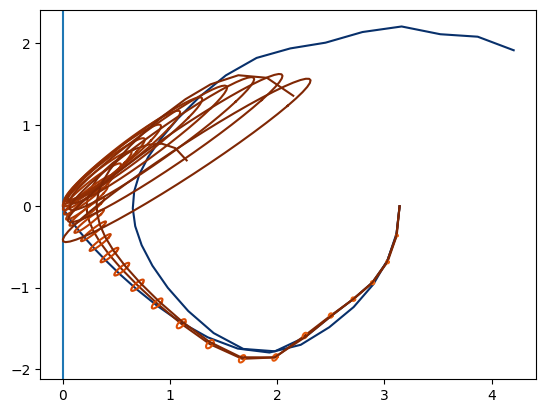

In [2]:
from l4acados.models import GPyTorchResidualModel

# + metadata={}
residual_model = GPyTorchResidualModel(gp_model)

# + metadata={}
residual_model.evaluate(x_plot_waypts[0:3, :])

# + metadata={}
residual_model.jacobian(x_plot_waypts[0:3, :])

# + metadata={}
residual_model.value_and_jacobian(x_plot_waypts[0:3, :])
# -

# create zoro_description
zoro_description = ZoroDescription()
zoro_description.backoff_scaling_gamma = norm.ppf(prob_x)
zoro_description.P0_mat = Sigma_x0
zoro_description.fdbk_K_mat = np.zeros((nu, nx))
# zoro_description.unc_jac_G_mat = B
"""G in (nx, nw) describes how noise affects dynamics. I.e. x+ = ... + G@w"""
zoro_description.W_mat = Sigma_W
"""W in (nw, nw) describes the covariance of the noise on the system"""
zoro_description.input_P0_diag = True
zoro_description.input_P0 = False
zoro_description.input_W_diag = True
zoro_description.input_W_add_diag = True
zoro_description.output_P_matrices = True
zoro_description.idx_lh_t = [0]
zoro_description.idx_lh_e_t = [0]
ocp_init.zoro_description = zoro_description

# + metadata={}
residual_mpc = ZeroOrderGPMPC(
    ocp_init,
    residual_model=residual_model,
    use_cython=False,
    path_json_ocp="residual_mpc_ocp_solver_config.json",
    path_json_sim="residual_mpc_sim_solver_config.json",
    build_c_code=True,
)

# + metadata={}
for i in range(N):
    residual_mpc.ocp_solver.set(i, "x", X_init[i, :])
    residual_mpc.ocp_solver.set(i, "u", U_init[i, :])
residual_mpc.ocp_solver.set(N, "x", X_init[N, :])

residual_mpc.solve(acados_sqp_mode=True)
X_res, U_res = residual_mpc.get_solution()
P_res_arr = residual_mpc.covariances_array

P_res = []
for i in range(N + 1):
    P_res.append(P_res_arr[i * nx**2 : (i + 1) * nx**2].reshape((nx, nx)))
P_res = np.array(P_res)

# + metadata={}
X_res_sim = np.zeros_like(X_res)
X_res_sim[0, :] = x0
for i in range(N):
    acados_integrator_actual.set("x", X_res_sim[i, :])
    acados_integrator_actual.set("u", U_res[i, :])
    acados_integrator_actual.solve()
    X_res_sim[i + 1, :] = acados_integrator_actual.get("x")

# + metadata={}
lb_theta = -ocp_init.constraints.lh[0]
fig, ax = base_plot(lb_theta=lb_theta)

plot_data_res = EllipsoidTubeData2D(center_data=X_res, ellipsoid_data=P_res)
plot_data_res_sim = EllipsoidTubeData2D(center_data=X_res_sim, ellipsoid_data=None)
add_plot_trajectory(ax, plot_data_nom, color_fun=plt.cm.Blues)
add_plot_trajectory(ax, plot_data_nom_sim, color_fun=plt.cm.Blues)
add_plot_trajectory(
    ax, plot_data_res, prob_tighten=prob_tighten, color_fun=plt.cm.Oranges
)
add_plot_trajectory(ax, plot_data_res_sim, color_fun=plt.cm.Oranges)

In [3]:
residual_mpc.print_statistics()

iter    res_stat        res_eq          res_ineq        res_comp
0       2.617994e+00    8.250256e-02    1.012514e+00    0.000000e+00
1       1.187356e-01    2.796424e-02    1.696322e-01    4.267595e+00
2       3.438675e-02    1.687336e-03    0.000000e+00    8.627382e-01
3       6.093326e-03    6.081222e-05    2.781307e-03    7.839229e-02
4       5.806168e-04    7.670240e-07    0.000000e+00    1.294152e-02
5       1.395773e-04    1.065613e-06    2.234026e-04    6.312271e-03
6       5.688909e-05    1.205310e-06    0.000000e+00    2.824488e-03
7       2.302354e-05    7.245023e-07    1.793250e-05    5.067406e-04
8       1.350477e-05    1.562032e-06    0.000000e+00    1.520120e-04
9       1.953509e-05    1.004447e-06    1.836323e-05    5.189189e-04
10      8.328352e-06    1.079630e-06    8.263697e-07    1.318151e-05


In [4]:
residual_mpc.get_stats("res_stat_all")

array([2.61799388e+00, 1.18735646e-01, 3.43867539e-02, 6.09332624e-03,
       5.80616754e-04, 1.39577325e-04, 5.68890862e-05, 2.30235358e-05,
       1.35047658e-05, 1.95350883e-05, 8.32835229e-06])

In [5]:
residual_mpc.get_stats("residuals")

array([8.32835229e-06, 1.07963023e-06, 8.26369695e-07, 1.31815107e-05])

In [6]:
residual_mpc.get_stats("time_preparation_all"), residual_mpc.get_stats(
    "time_preparation"
)

(array([0.01081292, 0.0140355 , 0.01196859, 0.00906953, 0.01094396,
        0.01395452, 0.0103701 , 0.0144724 , 0.00916382, 0.01340532,
        0.01174091]),
 np.float64(0.01174091299981228))